# Bike-sharing System

We now import the Gurobi Python Module and other packages. Then, we initialize the data structures with the given data.


In [45]:
import gurobipy as gp
from gurobipy import GRB

# tested with Gurobi v10.0.1 and Python 3.7.0

In [46]:
import matplotlib.pyplot as plt

In [47]:
import pandas as pd
import numpy as np

 Plot All 250 Points

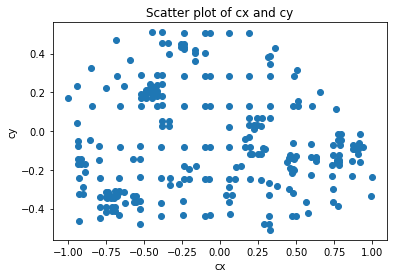

In [48]:
df = pd.read_csv("/Users/macbook/Desktop/FLP250.csv")

# Plot the scatter plot
plt.scatter(df['cx'], df['cy'])

# Set axis labels
plt.xlabel('cx')
plt.ylabel('cy')

# Set plot title
plt.title('Scatter plot of cx and cy')

# Display the plot
plt.show()

# Determine the list of potential locations by K-Means

Basically, we must define the budget. Based on the budget, we would have the maximum of stations. Once we obtain the maximum number of stations, we perform K-Means clustering to determine the centroid of each cluster. The centroid of the clusters will serve as the list of potential locations.

We can choose our different scenarios based on the budget (the more budget, the more potential locations)

In [102]:
from sklearn.cluster import KMeans


In [103]:
X = df.iloc[:,[0,1]].values
X

array([[ 0.190337,  0.129534],
       [ 0.33027 ,  0.129117],
       [ 1.      , -0.236398],
       [ 0.192887,  0.284568],
       [-0.522416, -0.078536],
       [-0.383335,  0.132982],
       [-0.382236,  0.50974 ],
       [ 0.597432, -0.065795],
       [ 0.87223 , -0.073424],
       [ 0.86765 , -0.234099],
       [ 0.597562, -0.22625 ],
       [ 0.321781, -0.43602 ],
       [ 0.603028,  0.128305],
       [ 0.057461, -0.083391],
       [ 0.064613, -0.428803],
       [-0.098252,  0.284202],
       [-0.525295, -0.238965],
       [ 0.058054,  0.284538],
       [-0.386262, -0.436937],
       [ 0.059822, -0.290127],
       [-0.524856, -0.481592],
       [-0.92365 , -0.462195],
       [ 0.565913, -0.367909],
       [ 0.738938, -0.176677],
       [ 0.784687, -0.124696],
       [ 0.060471, -0.366554],
       [ 0.328592,  0.388708],
       [ 0.740307, -0.363716],
       [-0.746703,  0.220441],
       [ 0.479941, -0.059941],
       [ 0.059009,  0.129932],
       [ 0.484135,  0.283715],
       [

## If maximum number of locations is 20

In [104]:
kmeans = KMeans(n_clusters=7, random_state=0)
# Fit the data points to the KMeans model
kmeans.fit(X)

# Get the centroids of each cluster
centroids = kmeans.cluster_centers_

# Get the labels of each data point
labels = kmeans.labels_

# Print the centroids and labels
print("Centroids: ", centroids)
print("Labels: ", labels)


Centroids:  [[-0.51717948  0.18636877]
 [ 0.38019832 -0.23456962]
 [-0.73883033 -0.28643751]
 [-0.12864041 -0.26899883]
 [ 0.31030352  0.16178155]
 [-0.19199716  0.38624284]
 [ 0.80097337 -0.13467937]]
Labels:  [4 4 6 4 0 0 5 6 6 6 1 1 4 3 3 5 2 5 3 3 2 2 1 6 6 3 4 6 0 1 4 4 4 4 5 3 3
 1 5 2 2 2 0 0 0 0 5 1 1 5 3 5 3 3 1 1 6 6 2 0 0 4 5 3 1 3 1 5 3 3 3 2 2 5
 5 2 1 1 1 1 6 6 4 4 4 0 0 6 4 6 3 3 2 0 0 0 3 6 6 2 3 2 4 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 3 1 1 1 3 1 1 6 6 6 6 6 6 6 6 6 2 2 6 5 1 1 1 1
 1 4 4 4 4 1 4 4 4 1 1 3 1 1 1 1 1 1 1 2 2 2 2 2 3 3 5 5 5 5 3 3 2 2 2 2 2
 2 2 2 2 2 3 2 2 2 2 2 2 2 2 4 4 5 5 5 5 5 5 5 5 2 2 4 4 4 4 4 6 6 6 6 6 6
 6 6 6 6 6 6 2 2 2 2 2 0 0 2 2 0 0 0 0 1 6 2 2 2 2 2 2 2 2 3 3]


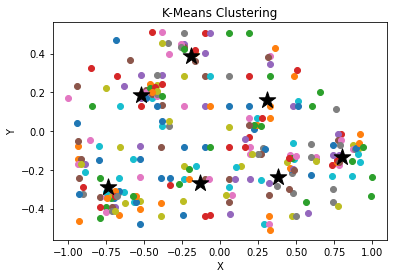

In [105]:
colors = ['r', 'g', 'b']
for i in range(len(X)):
    plt.scatter(X[i, 0], X[i, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300, color='black')
plt.title('K-Means Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [53]:
# select all columns except the first one
df = df.iloc[:, 1:]
df

,cx,cy
0,0.190337,0.129534
1,0.330270,0.129117
2,1.000000,-0.236398
3,0.192887,0.284568
4,-0.522416,-0.078536
...,...,...
248,-0.914627,-0.169495
249,-0.884190,-0.213610
250,-0.926032,-0.326334
251,-0.203863,-0.247862


# Solution Approach:  Modeling in Gurobi

## Instance 0:
### Baseline model without coef of distance
### Sets:

* I: Set of potential bike station locations
* J: Set of demand points in the downtown area

### Constants:

* c_ij: Euclidean distance between demand point j from bike station i 
* f_i: Fixed cost of building a bike station at location i (5000 dollars)
* d_j: Demand per point j (1-3 bikes)
* S: Maximum station capacity (100 bikes)
* B: Total city budget for the project (assumption 50000 dollars)



### Objective:
Minimize total distance (assume the unit is cost) and fixed costs:
* min ∑∑ c_ij * y_ij + ∑ f_i * x_i

### Decision variables:

* x_i: Binary decision variable, 1 if a bike station is built at location i, 0 otherwise
* y_ij: Binary decision variable, 1 if demand point j is covered by bike station i, 0 otherwise

### Constraints:

Each demand point can covered by at most one bike station:
* ∑ y_ij <= 1 for all j in J

A demand point can only be covered by a bike station if it exists:
* y_ij <= x_i for all i in I and j in J

Each bike station must not exceed its capacity:
* ∑ d_j * y_ij <= S * x_i for all i in I

Number of bike demand points between 100-253
* ∑ y_ij fir all i in I and j in J >=100 & <=253

Total budget constraint:
* ∑∑ c_ij * y_ij + ∑ f_i * x_i <= B

In [112]:
# Parameters
min_points = 100
max_points = 253
station_fix_cost = 5000
station_cap = 100

##Without coef of distance

##Assumption:
budget = 50000

# set the seed value
np.random.seed(42)

points = df.to_numpy()
n_points = len(points)
demand = np.random.randint(1, 4, n_points)  # Assuming random demand of 1-3 bikes per point

# Calculate distance matrix (c_ij)
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

distance_matrix = np.array([[euclidean_distance(p1, p2) for p2 in points] for p1 in points])

# Define the model
m0 = gp.Model("bike_sharing_0")

# Decision variables
x = m0.addVars(n_points, vtype=GRB.BINARY, name="x")
y = m0.addVars(n_points, n_points, vtype=GRB.BINARY, name="y")

# Objective function
m0.setObjective(gp.quicksum(distance_matrix[i, j] * y[i, j] for i in range(n_points) for j in range(n_points)) + station_fix_cost * gp.quicksum(x[i] for i in range(n_points)), GRB.MINIMIZE)

# Constraints
for j in range(n_points):
    m0.addConstr(gp.quicksum(y[i, j] for i in range(n_points)) <= 1, name=f"Cover_demand_point_{j}")

for i in range(n_points):
    for j in range(n_points):
        m0.addConstr(y[i, j] <= x[i], name=f"Cover_if_exists_{i}_{j}")


m0.addConstr(gp.quicksum(y[i, j] for i in range(n_points) for j in range(n_points)) >= min_points, name="Min_points_covered")

m0.addConstr(gp.quicksum(y[i, j] for i in range(n_points) for j in range(n_points)) <= max_points, name="Max_points_covered")

for i in range(n_points):
    m0.addConstr(gp.quicksum(demand[j] * y[i, j] for j in range(n_points)) <= station_cap * x[i], name=f"Station_capacity_{i}")

m0.addConstr(gp.quicksum(distance_matrix[i, j] * y[i, j] for i in range(n_points) for j in range(n_points)) + gp.quicksum(station_fix_cost * x[i] for i in range(n_points)) <= budget, name="Budget_constraint")




<gurobi.Constr *Awaiting Model Update*>

In [113]:
# Optimize the model without tuning
m0.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 64518 rows, 64262 columns and 448316 nonzeros
Model fingerprint: 0xc8918034
Variable types: 0 continuous, 64262 integer (64262 binary)
Coefficient statistics:
  Matrix range     [6e-03, 5e+03]
  Objective range  [6e-03, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 1 rows and 0 columns
Presolve time: 0.95s
Presolved: 64517 rows, 64262 columns, 384307 nonzeros
Variable types: 0 continuous, 64262 integer (64262 binary)

Interrupt request received

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   73668    5.8309160e+03   0.000000e+00   2.670010e+05      5s
   89225    5.6024754e+03   0.000000e+00   1.606495e+04     10s
   98231    5.5851551e+03   0.000000e+00   3.87

In [114]:
## Function for gutobi solution and visualization

def output(m):
    print("Min cost: ", m.objVal)
    for v in m.getVars():
        if v.x >0:
            print(v.varName,':', v.x)
            #print(v)


    # Extract the x and y variable objects
    x_vars = [var for var in m.getVars() if var.VarName.startswith('x')]
    y_vars = [var for var in m.getVars() if var.VarName.startswith('y')]

    # Get the indices of the variables with non-zero values
    x_indices = [int(var.VarName.split('[')[1].split(']')[0]) for var in x_vars if var.X > 0.5]
    y_indices = [(int(var.VarName.split('[')[1].split(',')[0]), int(var.VarName.split(',')[1].split(']')[0])) for var in y_vars if var.X > 0.5]

    # Convert the indices to x and y values
    x_points = [index for index in x_indices]
    y_points = [(index[0], index[1]) for index in y_indices]

    #visualize
    ans = x_points
    x = []
    for i in range(len(y_points)):
        x.append(y_points[i][1])
        
    ## Allocation
    print('\nAllocation solution: \n')
    print('\nStation: ', ans)
    print('\nDemand Points: ', x,'\n')
    print('\nDemand Points: ', len(x),'\n')

    # Plot the scatter plot
    selected_df = df.iloc[x]
    plt.scatter(selected_df['cx'], selected_df['cy'])


    selected_df_station = df.iloc[ans]
    #print(selected_df_station)
    for i in ans:
        plt.plot(selected_df_station['cx'], selected_df_station['cy'], 'ro')

    # Add labels and title

    # Set axis labels
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')

    # Set plot title
    plt.title('Plot of Demand Points')

    # Display the plot
    plt.show()

Min cost:  10020.180901917684
x[57] : 1.0
x[210] : 1.0
y[57,2] : 1.0
y[57,7] : 1.0
y[57,8] : 1.0
y[57,9] : 1.0
y[57,10] : 1.0
y[57,22] : 1.0
y[57,23] : 1.0
y[57,24] : 1.0
y[57,27] : 1.0
y[57,29] : 1.0
y[57,56] : 1.0
y[57,57] : 1.0
y[57,80] : 1.0
y[57,81] : 1.0
y[57,87] : 1.0
y[57,89] : 1.0
y[57,97] : 1.0
y[57,98] : 1.0
y[57,127] : 1.0
y[57,129] : 1.0
y[57,131] : 1.0
y[57,132] : 1.0
y[57,133] : 1.0
y[57,134] : 1.0
y[57,135] : 1.0
y[57,136] : 1.0
y[57,137] : 1.0
y[57,138] : 1.0
y[57,139] : 1.0
y[57,142] : 1.0
y[57,160] : 1.0
y[57,162] : 1.0
y[57,164] : 1.0
y[57,165] : 1.0
y[57,166] : 1.0
y[57,216] : 1.0
y[57,217] : 1.0
y[57,218] : 1.0
y[57,219] : 1.0
y[57,220] : 1.0
y[57,221] : 1.0
y[57,222] : 1.0
y[57,223] : 1.0
y[57,224] : 1.0
y[57,225] : 1.0
y[57,226] : 1.0
y[57,227] : 1.0
y[57,242] : 1.0
y[210,4] : 1.0
y[210,5] : 1.0
y[210,16] : 1.0
y[210,39] : 1.0
y[210,43] : 1.0
y[210,58] : 1.0
y[210,59] : 1.0
y[210,69] : 1.0
y[210,71] : 1.0
y[210,90] : 1.0
y[210,91] : 1.0
y[210,92] : 1.0
y[210,95]

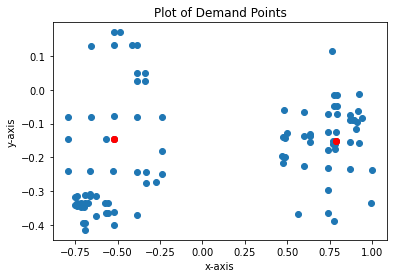

In [115]:
output(m0)

# Instance 1:

### Add coef of distance between station and demand points

### Sets:

* I: Set of potential bike station locations
* J: Set of demand points in the downtown area

### Constants:

* c_ij: Euclidean distance between demand point j from bike station i 
* f_i: Fixed cost of building a bike station at location i (5000 dollars)
* d_j: Demand per point j (1-3 bikes)
* S: Maximum station capacity (100 bikes)
* B: Total city budget for the project (assumption 50000 dollars)
* Coef = 1000 , cost per unit of distance (assumption)


### Objective:
Minimize total distance * coef and fixed costs:
* min ∑∑ c_ij * y_ij * coef + ∑ f_i * x_i

### Decision variables:

* x_i: Binary decision variable, 1 if a bike station is built at location i, 0 otherwise
* y_ij: Binary decision variable, 1 if demand point j is covered by bike station i, 0 otherwise

### Constraints:

Each demand point can covered by at most one bike station:
* ∑ y_ij <= 1 for all j in J

A demand point can only be covered by a bike station if it exists:
* y_ij <= x_i for all i in I and j in J

Each bike station must not exceed its capacity:
* ∑ d_j * y_ij <= S * x_i for all i in I

Number of bike demand points between 100-253
* ∑ y_ij fir all i in I and j in J >=100 & <=253

Total budget constraint:
* ∑∑ c_ij * y_ij * coef + ∑ f_i * x_i <= B

In [85]:
# Parameters
min_points = 100
max_points = 253
station_fix_cost = 5000
station_cap = 100



##Assumption:
budget = 50000
coef = 1000

# set the seed value
np.random.seed(42)

points = df.to_numpy()
n_points = len(points)
demand = np.random.randint(1, 4, n_points)  # Assuming random demand of 1-3 bikes per point

# Calculate distance matrix (c_ij)
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

distance_matrix = np.array([[euclidean_distance(p1, p2) for p2 in points] for p1 in points])

# Define the model
m = gp.Model("bike_sharing")

# Decision variables
x = m.addVars(n_points, vtype=GRB.BINARY, name="x")
y = m.addVars(n_points, n_points, vtype=GRB.BINARY, name="y")

# Objective function
m.setObjective(gp.quicksum(distance_matrix[i, j] * y[i, j] for i in range(n_points) for j in range(n_points))*coef + station_fix_cost * gp.quicksum(x[i] for i in range(n_points)), GRB.MINIMIZE)

# Constraints
for j in range(n_points):
    m.addConstr(gp.quicksum(y[i, j] for i in range(n_points)) <= 1, name=f"Cover_demand_point_{j}")

for i in range(n_points):
    for j in range(n_points):
        m.addConstr(y[i, j] <= x[i], name=f"Cover_if_exists_{i}_{j}")


m.addConstr(gp.quicksum(y[i, j] for i in range(n_points) for j in range(n_points)) >= min_points, name="Min_points_covered")

m.addConstr(gp.quicksum(y[i, j] for i in range(n_points) for j in range(n_points)) <= max_points, name="Max_points_covered")

for i in range(n_points):
    m.addConstr(gp.quicksum(demand[j] * y[i, j] for j in range(n_points)) <= station_cap * x[i], name=f"Station_capacity_{i}")

m.addConstr(gp.quicksum(distance_matrix[i, j] * y[i, j] for i in range(n_points) for j in range(n_points))*coef + gp.quicksum(station_fix_cost * x[i] for i in range(n_points)) <= budget, name="Budget_constraint")



<gurobi.Constr *Awaiting Model Update*>

In [86]:
# Optimize the model without tuning
m.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 64518 rows, 64262 columns and 448316 nonzeros
Model fingerprint: 0x35a0f241
Variable types: 0 continuous, 64262 integer (64262 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [6e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 1 rows and 0 columns
Presolve time: 1.06s
Presolved: 64517 rows, 64262 columns, 384307 nonzeros
Variable types: 0 continuous, 64262 integer (64262 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.407315e+04, 7595 iterations, 1.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     

In [106]:
## Function for gutobi solution and visualization
def output(m):
    print("Min cost: ", m.objVal)
    for v in m.getVars():
        if v.x >0:
            print(v.varName,':', v.x)
            #print(v)


    # Extract the x and y variable objects
    x_vars = [var for var in m.getVars() if var.VarName.startswith('x')]
    y_vars = [var for var in m.getVars() if var.VarName.startswith('y')]

    # Get the indices of the variables with non-zero values
    x_indices = [int(var.VarName.split('[')[1].split(']')[0]) for var in x_vars if var.X > 0.5]
    y_indices = [(int(var.VarName.split('[')[1].split(',')[0]), int(var.VarName.split(',')[1].split(']')[0])) for var in y_vars if var.X > 0.5]

    # Convert the indices to x and y values
    x_points = [index for index in x_indices]
    y_points = [(index[0], index[1]) for index in y_indices]

    #visualize
    ans = x_points
    x = []
    for i in range(len(y_points)):
        x.append(y_points[i][1])
        
    ## Allocation
    print('\nAllocation solution: \n')
    print('\nStation: ', ans)
    print('\nDemand Points: ', x,'\n')
    print('\nDemand Points: ', len(x),'\n')

    # Plot the scatter plot
    selected_df = df.iloc[x]
    plt.scatter(selected_df['cx'], selected_df['cy'])


    selected_df_station = df.iloc[ans]
    #print(selected_df_station)
    for i in ans:
        plt.plot(selected_df_station['cx'], selected_df_station['cy'], 'ro')

    # Add labels and title

    # Set axis labels
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')

    # Set plot title
    plt.title('Plot of Demand Points')

    # Display the plot
    plt.show()

Min cost:  24358.944003873392
x[24] : 1.0
x[115] : 1.0
x[180] : 1.0
y[24,7] : 1.0
y[24,8] : 1.0
y[24,9] : 1.0
y[24,10] : 1.0
y[24,23] : 1.0
y[24,24] : 1.0
y[24,56] : 1.0
y[24,57] : 1.0
y[24,80] : 1.0
y[24,81] : 1.0
y[24,89] : 1.0
y[24,97] : 1.0
y[24,131] : 1.0
y[24,132] : 1.0
y[24,133] : 1.0
y[24,134] : 1.0
y[24,135] : 1.0
y[24,136] : 1.0
y[24,137] : 1.0
y[24,138] : 1.0
y[24,139] : 1.0
y[24,142] : 1.0
y[24,216] : 1.0
y[24,217] : 1.0
y[24,218] : 1.0
y[24,219] : 1.0
y[24,220] : 1.0
y[24,221] : 1.0
y[24,222] : 1.0
y[24,223] : 1.0
y[24,224] : 1.0
y[24,225] : 1.0
y[24,226] : 1.0
y[24,227] : 1.0
y[115,5] : 1.0
y[115,43] : 1.0
y[115,44] : 1.0
y[115,46] : 1.0
y[115,94] : 1.0
y[115,103] : 1.0
y[115,104] : 1.0
y[115,105] : 1.0
y[115,106] : 1.0
y[115,107] : 1.0
y[115,108] : 1.0
y[115,109] : 1.0
y[115,110] : 1.0
y[115,111] : 1.0
y[115,112] : 1.0
y[115,113] : 1.0
y[115,114] : 1.0
y[115,115] : 1.0
y[115,116] : 1.0
y[115,117] : 1.0
y[115,118] : 1.0
y[115,120] : 1.0
y[115,121] : 1.0
y[115,122] : 1.0
y

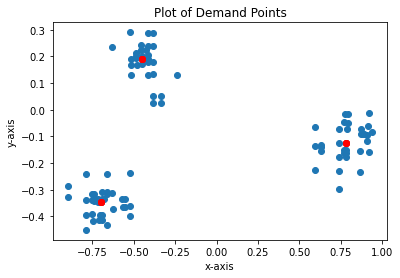

In [107]:
output(m)

# Instance 2:
## Min Number of bike demand points changed from 100 to150 with adding coef

### Sets:

* I: Set of potential bike station locations
* J: Set of demand points in the downtown area

### Constants:

* c_ij: Euclidean distance between demand point j from bike station i 
* f_i: Fixed cost of building a bike station at location i ($5000)
* d_j: Demand per point j (1-3 bikes)
* S: Maximum station capacity (100 bikes)
* B: Total city budget for the project (assumption 50000 dollars)
* Coef = 1000 , cost per unit of distance (assumption)


### Objective:
Minimize total distance * coef and fixed costs:
* min ∑∑ c_ij * y_ij * coef + ∑ f_i * x_i

### Decision variables:

* x_i: Binary decision variable, 1 if a bike station is built at location i, 0 otherwise
* y_ij: Binary decision variable, 1 if demand point j is covered by bike station i, 0 otherwise

### Constraints:

Each demand point can covered by at most one bike station:
* ∑ y_ij <= 1 for all j in J

A demand point can only be covered by a bike station if it exists:
* y_ij <= x_i for all i in I and j in J

Each bike station must not exceed its capacity:
* ∑ d_j * y_ij <= S * x_i for all i in I

Number of bike demand points between 150-253
* ∑ y_ij fir all i in I and j in J >=150 & <=253

Total budget constraint:
* ∑∑ c_ij * y_ij * coef + ∑ f_i * x_i <= B

In [89]:
# Parameters
min_points = 150
max_points = 253
station_fix_cost = 5000
station_cap = 100
coef = 1000


##Assumption:
budget = 50000

# set the seed value
np.random.seed(42)
points = df.to_numpy()
n_points = len(points)
demand = np.random.randint(1, 4, n_points)  # Assuming random demand of 1-3 bikes per point

# Calculate distance matrix (c_ij)
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

distance_matrix = np.array([[euclidean_distance(p1, p2) for p2 in points] for p1 in points])

# Define the model
m2 = gp.Model("bike_sharing")

# Decision variables
x = m2.addVars(n_points, vtype=GRB.BINARY, name="x")
y = m2.addVars(n_points, n_points, vtype=GRB.BINARY, name="y")

# Objective function
m2.setObjective(gp.quicksum(distance_matrix[i, j] * y[i, j] for i in range(n_points) for j in range(n_points))*coef + station_fix_cost * gp.quicksum(x[i] for i in range(n_points)), GRB.MINIMIZE)

# Constraints
for j in range(n_points):
    m2.addConstr(gp.quicksum(y[i, j] for i in range(n_points)) <= 1, name=f"Cover_demand_point_{j}")

for i in range(n_points):
    for j in range(n_points):
        m2.addConstr(y[i, j] <= x[i], name=f"Cover_if_exists_{i}_{j}")


m2.addConstr(gp.quicksum(y[i, j] for i in range(n_points) for j in range(n_points)) >= min_points, name="Min_points_covered")

m2.addConstr(gp.quicksum(y[i, j] for i in range(n_points) for j in range(n_points)) <= max_points, name="Max_points_covered")

for i in range(n_points):
    m2.addConstr(gp.quicksum(demand[j] * y[i, j] for j in range(n_points)) <= station_cap * x[i], name=f"Station_capacity_{i}")

m2.addConstr(gp.quicksum(distance_matrix[i, j] * y[i, j] for i in range(n_points) for j in range(n_points))*coef + gp.quicksum(station_fix_cost * x[i] for i in range(n_points)) <= budget, name="Budget_constraint")




<gurobi.Constr *Awaiting Model Update*>

In [93]:
# Optimize the model without tuning
m2.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 64518 rows, 64262 columns and 448316 nonzeros
Model fingerprint: 0x35671fe1
Variable types: 0 continuous, 64262 integer (64262 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [6e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 1 rows and 0 columns
Presolve time: 1.11s
Presolved: 64517 rows, 64262 columns, 384307 nonzeros
Variable types: 0 continuous, 64262 integer (64262 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.752143e+04, 9000 iterations, 1.71 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     

Min cost:  37931.32228759481
x[24] : 1.0
x[37] : 1.0
x[121] : 1.0
x[180] : 1.0
y[24,7] : 1.0
y[24,8] : 1.0
y[24,9] : 1.0
y[24,10] : 1.0
y[24,23] : 1.0
y[24,24] : 1.0
y[24,56] : 1.0
y[24,57] : 1.0
y[24,80] : 1.0
y[24,81] : 1.0
y[24,87] : 1.0
y[24,89] : 1.0
y[24,97] : 1.0
y[24,131] : 1.0
y[24,132] : 1.0
y[24,133] : 1.0
y[24,134] : 1.0
y[24,135] : 1.0
y[24,136] : 1.0
y[24,137] : 1.0
y[24,138] : 1.0
y[24,139] : 1.0
y[24,142] : 1.0
y[24,216] : 1.0
y[24,217] : 1.0
y[24,218] : 1.0
y[24,219] : 1.0
y[24,220] : 1.0
y[24,221] : 1.0
y[24,222] : 1.0
y[24,223] : 1.0
y[24,224] : 1.0
y[24,225] : 1.0
y[24,226] : 1.0
y[24,227] : 1.0
y[37,0] : 1.0
y[37,1] : 1.0
y[37,13] : 1.0
y[37,29] : 1.0
y[37,33] : 1.0
y[37,37] : 1.0
y[37,64] : 1.0
y[37,66] : 1.0
y[37,76] : 1.0
y[37,77] : 1.0
y[37,78] : 1.0
y[37,79] : 1.0
y[37,127] : 1.0
y[37,129] : 1.0
y[37,130] : 1.0
y[37,144] : 1.0
y[37,145] : 1.0
y[37,146] : 1.0
y[37,147] : 1.0
y[37,148] : 1.0
y[37,149] : 1.0
y[37,150] : 1.0
y[37,151] : 1.0
y[37,152] : 1.0
y[37,15

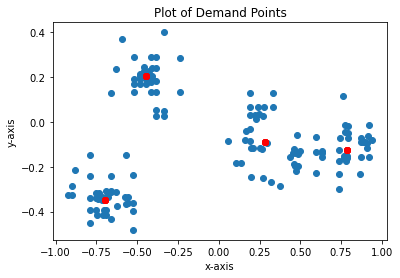

In [108]:
output(m2)

## Instance 3:
### Min Number of bike demand points changed from 150 to 250 with adding coef
### Total Budget changed from 50000 to 80000

### Sets:

* I: Set of potential bike station locations
* J: Set of demand points in the downtown area

### Constants:

* c_ij: Euclidean distance between demand point j from bike station i 
* f_i: Fixed cost of building a bike station at location i ($5000)
* d_j: Demand per point j (1-3 bikes)
* S: Maximum station capacity (100 bikes)
* B: Total city budget for the project (assumption 80000 dollars)
* Coef = 1000 , cost per unit of distance (assumption)


### Objective:
Minimize total distance (assume the unit is money cost) and fixed costs:
* min ∑∑ c_ij * y_ij * coef + ∑ f_i * x_i

### Decision variables:

* x_i: Binary decision variable, 1 if a bike station is built at location i, 0 otherwise
* y_ij: Binary decision variable, 1 if demand point j is covered by bike station i, 0 otherwise

### Constraints:

Each demand point can covered by at most one bike station:
* ∑ y_ij <= 1 for all j in J

A demand point can only be covered by a bike station if it exists:
* y_ij <= x_i for all i in I and j in J

Each bike station must not exceed its capacity:
* ∑ d_j * y_ij <= S * x_i for all i in I

Number of bike demand points between 250-253
* ∑ y_ij fir all i in I and j in J >=250 & <=253

Total budget constraint:
* ∑∑ c_ij * y_ij * coef + ∑ f_i * x_i <= B

In [109]:
# Parameters
min_points = 250
max_points = 253
station_fix_cost = 5000
station_cap = 100
coef = 1000


##Assumption:
budget = 80000

# set the seed value make sure demand
np.random.seed(42)
points = df.to_numpy()
n_points = len(points)
demand = np.random.randint(1, 4, n_points)  # Assuming random demand of 1-3 bikes per point

# Calculate distance matrix (c_ij)
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

distance_matrix = np.array([[euclidean_distance(p1, p2) for p2 in points] for p1 in points])

# Define the model
m3 = gp.Model("bike_sharing")

# Decision variables
x = m3.addVars(n_points, vtype=GRB.BINARY, name="x")
y = m3.addVars(n_points, n_points, vtype=GRB.BINARY, name="y")

# Objective function
m3.setObjective(gp.quicksum(distance_matrix[i, j] * y[i, j] for i in range(n_points) for j in range(n_points))*coef + station_fix_cost * gp.quicksum(x[i] for i in range(n_points)), GRB.MINIMIZE)

# Constraints
for j in range(n_points):
    m3.addConstr(gp.quicksum(y[i, j] for i in range(n_points)) <= 1, name=f"Cover_demand_point_{j}")

for i in range(n_points):
    for j in range(n_points):
        m3.addConstr(y[i, j] <= x[i], name=f"Cover_if_exists_{i}_{j}")


m3.addConstr(gp.quicksum(y[i, j] for i in range(n_points) for j in range(n_points)) >= min_points, name="Min_points_covered")

m3.addConstr(gp.quicksum(y[i, j] for i in range(n_points) for j in range(n_points)) <= max_points, name="Max_points_covered")

for i in range(n_points):
    m3.addConstr(gp.quicksum(demand[j] * y[i, j] for j in range(n_points)) <= station_cap * x[i], name=f"Station_capacity_{i}")

m3.addConstr(gp.quicksum(distance_matrix[i, j] * y[i, j] for i in range(n_points) for j in range(n_points))*coef + gp.quicksum(station_fix_cost * x[i] for i in range(n_points)) <= budget, name="Budget_constraint")





<gurobi.Constr *Awaiting Model Update*>

In [110]:
# Optimize the model without tuning
m3.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 64518 rows, 64262 columns and 448316 nonzeros
Model fingerprint: 0x41494180
Variable types: 0 continuous, 64262 integer (64262 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [6e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
Presolve removed 1 rows and 0 columns
Presolve time: 0.99s
Presolved: 64517 rows, 64262 columns, 384307 nonzeros
Variable types: 0 continuous, 64262 integer (64262 binary)

Interrupt request received

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
  125966    8.0000000e+04   4.017621e+00   4.742132e+09      5s
  190723    7.8227226e+04   0.000000e+00   1.126818e+06     10s
Concurrent spin time: 0.00s

Solved with dual s

Min cost:  73602.22291344743
x[24] : 1.0
x[106] : 1.0
x[127] : 1.0
x[152] : 1.0
x[175] : 1.0
x[181] : 1.0
x[251] : 1.0
y[24,2] : 1.0
y[24,8] : 1.0
y[24,9] : 1.0
y[24,12] : 1.0
y[24,23] : 1.0
y[24,24] : 1.0
y[24,27] : 1.0
y[24,56] : 1.0
y[24,57] : 1.0
y[24,80] : 1.0
y[24,81] : 1.0
y[24,82] : 1.0
y[24,87] : 1.0
y[24,89] : 1.0
y[24,97] : 1.0
y[24,98] : 1.0
y[24,131] : 1.0
y[24,132] : 1.0
y[24,133] : 1.0
y[24,134] : 1.0
y[24,135] : 1.0
y[24,136] : 1.0
y[24,138] : 1.0
y[24,139] : 1.0
y[24,142] : 1.0
y[24,216] : 1.0
y[24,217] : 1.0
y[24,218] : 1.0
y[24,219] : 1.0
y[24,220] : 1.0
y[24,221] : 1.0
y[24,222] : 1.0
y[24,223] : 1.0
y[24,224] : 1.0
y[24,225] : 1.0
y[24,226] : 1.0
y[24,227] : 1.0
y[24,242] : 1.0
y[106,4] : 1.0
y[106,5] : 1.0
y[106,28] : 1.0
y[106,39] : 1.0
y[106,42] : 1.0
y[106,43] : 1.0
y[106,44] : 1.0
y[106,45] : 1.0
y[106,46] : 1.0
y[106,58] : 1.0
y[106,59] : 1.0
y[106,60] : 1.0
y[106,85] : 1.0
y[106,93] : 1.0
y[106,94] : 1.0
y[106,103] : 1.0
y[106,104] : 1.0
y[106,105] : 1.0
y[1

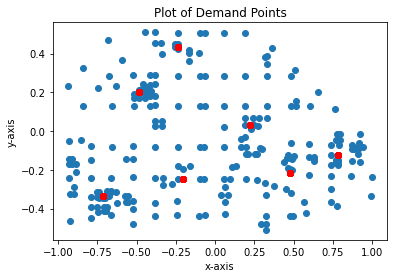

In [111]:
output(m3)

## Model Parameters Tuning

In [116]:

# Reset the values of the parameters
m3.resetParams() # DO NOT COMMENT

#######################

# Tune the model based on the selected parameters (see the parameter list).
# Terminate tuning to avoid massive running time
m3.setParam('tuneTimeLimit', 1000.0)

##Three parameters tuning
m3.setParam('Cuts', 2)
m3.setParam('BQPCuts', 1)
m3.setParam('FlowCoverCuts', 2)

# Tune the complete formulation (automatic tunning)
m3.tune()

Reset all parameters
Changed value of parameter tuneTimeLimit to 1000.0
   Prev: -1.0  Min: -1.0  Max: inf  Default: -1.0
Changed value of parameter Cuts to 2
   Prev: -1  Min: -1  Max: 3  Default: -1
Changed value of parameter BQPCuts to 1
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter FlowCoverCuts to 2
   Prev: -1  Min: -1  Max: 2  Default: -1

Solving model using baseline parameter set with TimeLimit=100s

Testing candidate parameter set 1...

	Cuts 2 (fixed)
	FlowCoverCuts 2 (fixed)
	BQPCuts 1 (fixed)

Solving with random seed #1 ...
Optimize a model with 64518 rows, 64262 columns and 448316 nonzeros
Model fingerprint: 0x41494180
Variable types: 0 continuous, 64262 integer (64262 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [6e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
Presolve removed 1 rows and 0 columns
Presolve time: 1.04s
Presolved: 64517 rows, 64262 columns, 384307 nonzeros
Var

In [117]:
# Optimize the model again
m3.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 64518 rows, 64262 columns and 448316 nonzeros
Model fingerprint: 0x41494180
Variable types: 0 continuous, 64262 integer (64262 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [6e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
Presolved: 64517 rows, 64262 columns, 384307 nonzeros

Continuing optimization...

   110    59     cutoff    8      73602.2229 73477.9373  0.17%  63.5   90s
H  322   156                    73578.988498 73477.9373  0.14%  52.5   94s
   352   172 73551.6008   10  309 73578.9885 73477.9373  0.14%  53.2   95s
  1566     0 73571.7732   21   66 73578.9885 73538.6826  0.05%  47.3  100s

Cutting planes:
  GUB cover: 1
  Zero half: 31

Explored 1624 nodes (185418 simplex iterations) in 10.10 seconds
Thread count was 8 (of 8 available processors)

Solutio

Min cost:  73578.9884983443
x[24] : 1.0
x[104] : 1.0
x[127] : 1.0
x[152] : 1.0
x[175] : 1.0
x[181] : 1.0
x[251] : 1.0
y[24,2] : 1.0
y[24,8] : 1.0
y[24,9] : 1.0
y[24,12] : 1.0
y[24,23] : 1.0
y[24,24] : 1.0
y[24,27] : 1.0
y[24,56] : 1.0
y[24,57] : 1.0
y[24,80] : 1.0
y[24,81] : 1.0
y[24,82] : 1.0
y[24,87] : 1.0
y[24,89] : 1.0
y[24,97] : 1.0
y[24,98] : 1.0
y[24,131] : 1.0
y[24,132] : 1.0
y[24,133] : 1.0
y[24,134] : 1.0
y[24,135] : 1.0
y[24,136] : 1.0
y[24,138] : 1.0
y[24,139] : 1.0
y[24,142] : 1.0
y[24,216] : 1.0
y[24,217] : 1.0
y[24,218] : 1.0
y[24,219] : 1.0
y[24,220] : 1.0
y[24,221] : 1.0
y[24,222] : 1.0
y[24,223] : 1.0
y[24,224] : 1.0
y[24,225] : 1.0
y[24,226] : 1.0
y[24,227] : 1.0
y[24,242] : 1.0
y[104,4] : 1.0
y[104,5] : 1.0
y[104,28] : 1.0
y[104,39] : 1.0
y[104,42] : 1.0
y[104,43] : 1.0
y[104,44] : 1.0
y[104,45] : 1.0
y[104,46] : 1.0
y[104,58] : 1.0
y[104,59] : 1.0
y[104,60] : 1.0
y[104,85] : 1.0
y[104,93] : 1.0
y[104,94] : 1.0
y[104,103] : 1.0
y[104,104] : 1.0
y[104,105] : 1.0
y[10

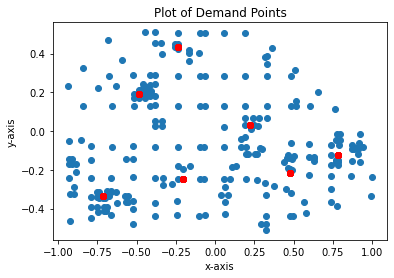

In [118]:
output(m3)


### Insights from model tune:
* Running time improved dramatically 
* Optimal solution of cost reduced
* only One station point changed
* Model refined overall